# Model Optimization and Evaluation


## 1. Setup and Data Loading

In [153]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Utils functions
import os
import sys

# Add the src directory to Python path to import our utils module
src_path = os.path.abspath("../../src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import feature engineering utilities from our custom module
from utils import (  # type: ignore
    confusion_matrix_analysis,
)

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)


# Styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📚 Libraries imported successfully!")
print(f"📍 Working directory: {os.getcwd()}")

📚 Libraries imported successfully!
📍 Working directory: /Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/notebooks/modeling


In [154]:
# Load preprocessed data
print("LOADING PREPROCESSED DATA:")
print("="*50)

# Define data paths
data_path = "../../data/processed"
X_file = os.path.join(data_path, "X_features.csv")
y_file = os.path.join(data_path, "y_target.csv")

# Load features and target
X = pd.read_csv(X_file)
y = pd.read_csv(y_file).squeeze()  # Convert to Series

print(f"✅ Features loaded: {X.shape}")
print(f"✅ Target loaded: {y.shape}")

print(f"\n📊 Dataset Summary:")
print(f"   Total samples: {len(X)}")
print(f"   Total features: {X.shape[1]}")
print(f"   Target variable: {y.name}")
print(f"   Target classes: {sorted(y.unique())}")
print(f"   Class distribution:")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    percentage = (count / len(y)) * 100
    print(f"     Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Data ready for modeling!")

LOADING PREPROCESSED DATA:
✅ Features loaded: (1470, 40)
✅ Target loaded: (1470,)

📊 Dataset Summary:
   Total samples: 1470
   Total features: 40
   Target variable: a_quitte_l_entreprise
   Target classes: [np.int64(0), np.int64(1)]
   Class distribution:
     Class 0: 1233 (83.9%)
     Class 1: 237 (16.1%)

🎯 Data ready for modeling!


In [155]:
X.head()

,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Marketing,domaine_etude_Ressources Humaines,domaine_etude_Transformation Digitale
0,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11.0,0,0,1,2,1,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23.0,1,3,8,1,2,1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15.0,0,3,2,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11.0,0,3,3,4,2,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12.0,1,3,2,1,1,2,2,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


## 2. Train/Test Split

In [156]:
# Create train/test split
print("TRAIN/TEST SPLIT:")
print("="*50)

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Train set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")

print(f"\n📊 Class distribution after split:")
print(f"\nTraining set:")
for class_val in sorted(y_train.unique()):
    count = (y_train == class_val).sum()
    percentage = (count / len(y_train)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\nTest set:")
for class_val in sorted(y_test.unique()):
    count = (y_test == class_val).sum()
    percentage = (count / len(y_test)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Stratified split completed!")

TRAIN/TEST SPLIT:
✅ Train set: (1176, 40)
✅ Test set: (294, 40)

📊 Class distribution after split:

Training set:
  Class 0: 986 (83.8%)
  Class 1: 190 (16.2%)

Test set:
  Class 0: 247 (84.0%)
  Class 1: 47 (16.0%)

🎯 Stratified split completed!


In [157]:
from sklearn.model_selection import GridSearchCV

# ================================
# Paramètres à tester pour GridSearch
# ================================
param_grid = {
    "rf__n_estimators": [200, 300, 400],
    "rf__max_depth": [6, 7, 8],
    "rf__min_samples_split": [4, 8, 12],
    "rf__min_samples_leaf": [2, 4, 6],
    "rf__max_features": ["sqrt", "log2"],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_weighted",  # ou 'recall' si priorité à la classe 1
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("✅ Meilleurs paramètres trouvés :")
print(grid_search.best_params_)
print(f"Meilleur F1-weighted (CV): {grid_search.best_score_:.4f}")

# Évaluation sur le test set
y_pred_test = grid_search.best_estimator_.predict(X_test)
y_pred_proba_test = grid_search.best_estimator_.predict_proba(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average="weighted", zero_division=0)
recall_test = recall_score(y_test, y_pred_test, average="weighted")
f1_test = f1_score(y_test, y_pred_test, average="weighted")

print(f"\n📊 Test Set Performance:")
print(f"Accuracy : {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall   : {recall_test:.4f}")
print(f"F1-Score : {f1_test:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
✅ Meilleurs paramètres trouvés :
{'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 4, 'rf__n_estimators': 200}
Meilleur F1-weighted (CV): 0.8333

📊 Test Set Performance:
Accuracy : 0.8299
Precision: 0.8270
Recall   : 0.8299
F1-Score : 0.8284


🔹 Optimal threshold: 0.078


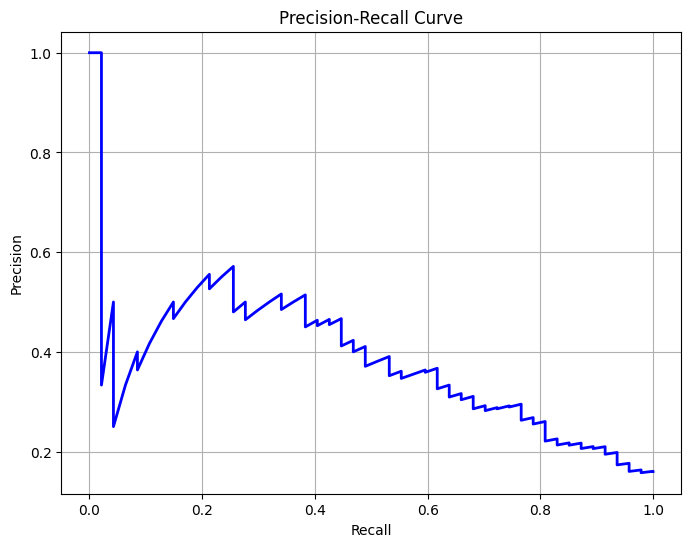

In [158]:
# =======================
# SEUIL OPTIMAL + PR CURVE
# =======================
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Probabilités sur l'ensemble de test avec le pipeline final
y_proba_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # classe 1

# Génération de la courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

# Logique simple pour choisir un seuil "optimal"
# Exemple : maximiser recall tout en gardant une précision acceptable
optimal_idx = np.argmax(recall - (1 - precision))  # tu peux adapter selon ton objectif
optimal_threshold = thresholds[optimal_idx]
print(f"🔹 Optimal threshold: {optimal_threshold:.3f}")

# Visualiser la courbe Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# Appliquer le seuil pour créer y_pred_final
y_pred_final = (y_proba_test >= 0.4).astype(int)

              precision    recall  f1-score   support

           0       0.91      0.77      0.84       247
           1       0.34      0.62      0.44        47

    accuracy                           0.74       294
   macro avg       0.63      0.69      0.64       294
weighted avg       0.82      0.74      0.77       294


=== CONFUSION MATRIX ANALYSIS for Random Forest Confusion Matrix ===
📊 Confusion Matrix:
   True labels (rows) vs Predicted labels (columns)
   Classes: [np.int64(0), np.int64(1)]

[[190  57]
 [ 18  29]]


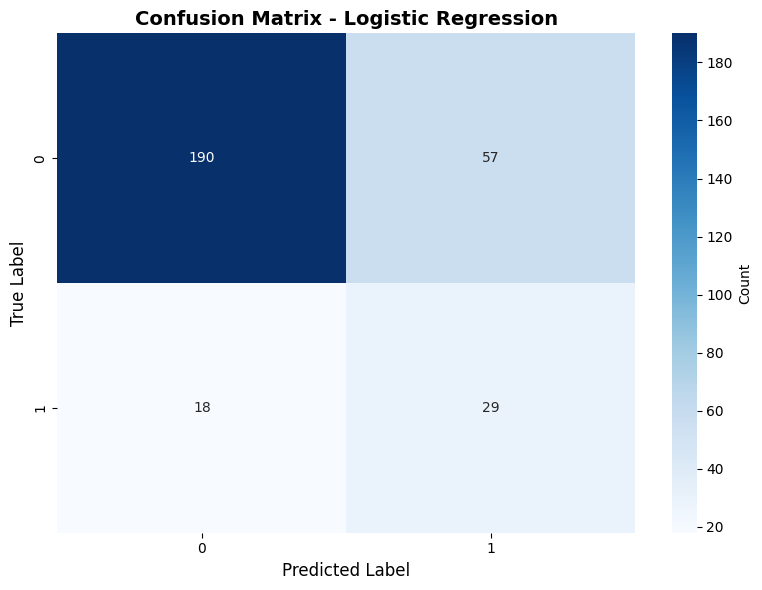


📈 Confusion Matrix Analysis:

   Class 0:
     True Positives:  190
     False Positives: 18
     False Negatives: 57
     True Negatives:  29
     Sensitivity (Recall): 0.7692
     Specificity:          0.6170
     Precision:            0.9135

🎯 Confusion Matrix completed!

   Class 1:
     True Positives:  29
     False Positives: 57
     False Negatives: 18
     True Negatives:  190
     Sensitivity (Recall): 0.6170
     Specificity:          0.7692
     Precision:            0.3372

🎯 Confusion Matrix completed!


In [159]:
# =======================
# ÉVALUATION DU MODELE
# =======================
from sklearn.metrics import classification_report



# Classification report
print(classification_report(y_test, y_pred_final))

# Confusion matrix
confusion_matrix_analysis(
    y_test, y_pred_final, model_name="Random Forest Confusion Matrix"
)

In [160]:
# Feature importance
feature_importance = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": grid_search.best_estimator_.named_steps[
            "rf"
        ].feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\n🔍 Top 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:<25} : {row['importance']:.4f}")


🔍 Top 10 Most Important Features:
    1. nombre_participation_pee  : 0.1129
    2. statut_marital_Marié(e)   : 0.0906
    3. satisfaction_employee_nature_travail : 0.0694
    4. revenu_mensuel            : 0.0582
    5. annes_sous_responsable_actuel : 0.0572
    6. departement_Consulting    : 0.0526
    7. satisfaction_employee_environnement : 0.0506
    8. statut_marital_Divorcé(e) : 0.0441
    9. age                       : 0.0425
   10. annee_experience_totale   : 0.0402
